<a href="https://colab.research.google.com/github/Luytic/colab/blob/main/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy


In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [4]:
def splits(dataset, Train_ratio, Val_ratio, Test_ratio):

  dataset_size = len(dataset)

  train_dataset = dataset.take(int(Train_ratio*dataset_size))

  val_test_dataset = dataset.skip(int(Train_ratio*dataset_size))
  val_dataset = val_test_dataset.take(int(Val_ratio*dataset_size))

  test_dataset = val_test_dataset.skip(int(Val_ratio*dataset_size))
  return train_dataset, val_dataset, test_dataset

In [5]:
Train_ratio = 0.6
Val_ratio = 0.2
Test_ratio = 0.2
train_dataset, val_dataset, test_dataset = splits(dataset[0], Train_ratio, Val_ratio, Test_ratio)

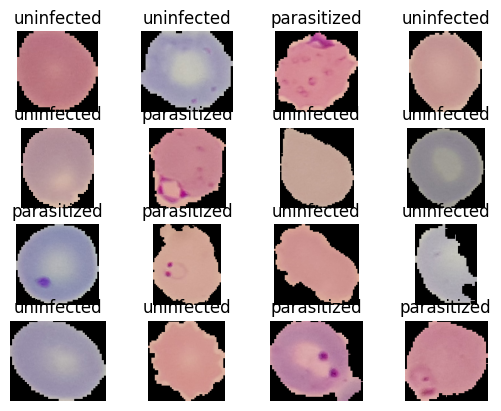

In [6]:
for i , (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4, i +1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [7]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [8]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [9]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


In [10]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    tf.keras.layers.Conv2D(filters=6,kernel_size= 3,strides=1,padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=16,kernel_size= 3,strides=1,padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),

])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [11]:
y_true = tf.constant([0, 1, 0,0])
y_pred = tf.constant([0.6, 0.51,0.94,1])
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0863576>

In [15]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy'])

In [16]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose = 1)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 47s 80ms/step - accuracy: 0.9288 - loss: 0.2073 - val_accuracy: 0.8768 - val_loss: 0.6495
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.9426 - loss: 0.1781 - val_accuracy: 0.7703 - val_loss: 0.4479
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.9482 - loss: 0.1545 - val_accuracy: 0.5556 - val_loss: 0.6164
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.9500 - loss: 0.1504 - val_accuracy: 0.9129 - val_loss: 0.2949
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.9536 - loss: 0.1431 - val_accuracy: 0.9329 - val_loss: 0.1927
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.9593 - loss: 0.1238 - val_accuracy: 0.9390 - val_loss: 0.1779
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.9592 - loss: 0.1206 - val_accuracy: 0.9379 - val_loss: 0.2077
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 78s 73ms/step - accuracy: 0.9614 - loss: 0.1144 - 

In [19]:
test_dataset = test_dataset.batch(1)

In [21]:
model.evaluate(test_dataset)

5513/5513 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9451 - loss: 0.1724


[0.18413661420345306, 0.9439506530761719]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


0.8528058

In [24]:
def parasite_or_not(x):
  if x < 0.5:
    return str('P')
  else:
    return str('U')

In [33]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


'P'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


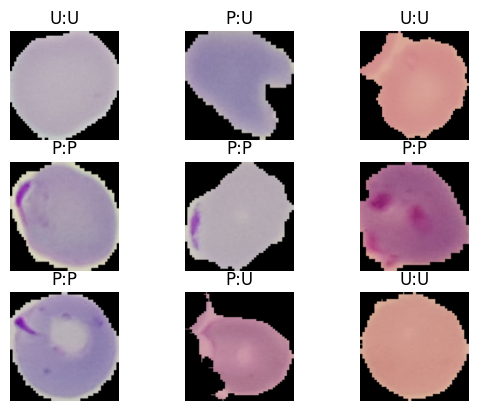

In [35]:

for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i +1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')